# Project Name 

**Project Type -** EDA

**Contribution -** Individual

**Rakshit Pandey**

## Project Summary

**Write the summary here within 500-600 words**.


## Github Link

**Provide your Github Link here.**

## Problem Statement

**Write Problem Statement Here.**

## Business Context

**Write Business Context Here**

### Define Your Business Objective ?

#### Answer Here

## Dataset Description

**Dataset** :  

**Data overview** :

## Let's Begin !

### Project Setup -- constants 

In [1]:
data_url = 'https://raw.githubusercontent.com/pandey-rakshit/data-library/main/Airbnb/Airbnb.csv' # (support raw files only) - extension - {csv, xlsx, json, parquet}
skew_threshold = 0.5
outlier_threshold = 1.5

In [118]:
column_names = {
    'price': 'Price',
    'minimum_nights': 'Minimum Nights',
    'number_of_reviews': 'Number of Reviews',
    'reviews_per_month': 'Reviews per Month',
    'calculated_host_listings_count': 'Number of Listings per Host',
    'availability_365': 'Availability (Days per Year)',
    'latitude': 'Latitude',
    'longitude': 'Longitude',
}


### Prerequisite

In [2]:
# Library Installation

!pip install scipy scikit-learn pandas numpy matplotlib seaborn wordcloud --quiet

### Imports

In [3]:
# Importing necessary libraries

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations, including mathematical functions like mean, median, sqrt, etc.

import matplotlib.pyplot as plt  # For creating a wide range of visualizations, such as bar plots, histograms, scatter plots, etc.
import seaborn as sns  # For advanced statistical visualizations, including pairplots, violin plots, and heatmaps

from scipy import stats  # For statistical functions like boxcox transformation, normality tests, correlation calculations, and more
from sklearn.preprocessing import PowerTransformer  # For data scaling and transformations, e.g., Yeo-Johnson for skewed data


from pathlib import Path

In [4]:
# Optional: Setting styles for plots
sns.set_style("darkgrid")

### Utilities

#### Visualizatioin - Utitlity

In [103]:
# chart visualzation function

plot_functions = {
    'scatter': sns.scatterplot,
    'line': sns.lineplot,
    'bar': sns.barplot,
    'hist': sns.histplot,
    'pie': plt.pie,
    'count': sns.countplot,
    'heatmap': sns.heatmap
}


def visualize_chart(chart_objs, nrows=1, ncols=1, **kwargs):
    """
    Create a custom visualization chart with optional subplots.

    Parameters:
    - chart_objs (list): List of dictionaries, where each dictionary contains
                          chart-specific information like 'plot_function', 'titles', etc.
    - nrows (int): Number of rows for the subplot grid. Default is 1.
    - ncols (int): Number of columns for the subplot grid. Default is 1.
    - **kwargs: Additional common keyword arguments passed to the plotting function.

    Returns:
    - fig (matplotlib.figure.Figure): The created figure object.
    """


    width = 12 if ncols == 1 else ncols * 5.43
    height = 6 if nrows == 1 else nrows * 4
    
    plt.figure(figsize=(width, height))
    
    # print(axes)
    
    # Loop through chart_objs to plot the respective data
    for i, chart in enumerate(chart_objs, 1):

        plot_function = chart['plot_function']
        title = chart['title']
        xlabel = chart['xlabel']
        ylabel = chart['ylabel']
        x = chart['x']
        y = chart.get('y', None)
        chart_kwargs = chart.get('kwargs', {})

        
        plt.subplot(nrows, ncols, i)
        
        # Construct the plotting function arguments
        # Adjust the plot_args dynamically based on the plot function
        plot_args = {'data': x} if plot_function == plot_functions['heatmap'] else {'x': x}
       
        if y is not None:
            plot_args['y'] = y
        
        # Add any additional keyword arguments for this specific chart
        plot_args.update(chart_kwargs)
        
        # Plot the chart on the appropriate subplot axis
        # sns.histplot(x=x, kde=True, color='purple', element='poly', ax=axes[i], **plot_args)

        # Call the plot function
        plot_function(**plot_args)

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        

    # Adjust layout for better readability
    plt.tight_layout()

    fig = plt.gcf()

    return fig


#### DataFrame - Utitlity

In [6]:
def get_file_extension_from_path(input_path):
    # Use Path on system path (e.g., relative or absolute)
    file_extension = Path(input_path).suffix.lstrip('.')
    return file_extension.lower()

In [7]:

def create_dataframe(data_url: str) -> pd.DataFrame:
    """
    Reads raw data from a URL or file path and creates a DataFrame.

    Args:
        data_url (str): URL or file path of the raw data (e.g., GitHub raw file).
        data_type (str): The type of the data ('csv', 'xlsx', 'json', 'parquet').

    Returns:
        pd.DataFrame: A pandas DataFrame containing the data.
        
    """
    # Map data types to pandas functions
    read_functions = {
        "csv": pd.read_csv,
        "xlsx": pd.read_excel,
        "json": pd.read_json,
        "parquet": pd.read_parquet,
    }

    data_type = get_file_extension_from_path(data_url)
    
    if data_type not in read_functions:
        raise ValueError(f"Unsupported data type: {data_type}")

    try:
        # Use the appropriate pandas function to read the data
        df = read_functions[data_type](data_url)
        return df

    except Exception as e:
        raise RuntimeError(f"Failed to create DataFrame: {e}")


In [8]:
def analyze_dataset(df, exclude_columns=None):
    """
    Performs analysis on the dataset and stores the results.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        exclude_columns (list): List of columns to exclude from summary statistics (optional).
    
    Returns:
        dict: A dictionary with the results of the analysis.
    """
    results = {}

    # General dataset info
    results['rows'], results['columns'] = df.shape

    # Missing values
    missing_count = df.isnull().sum()
    missing_details = missing_count[missing_count > 0].to_dict()
    total_missing = missing_count.sum()
    results['missing_values'] = {
        'total': total_missing,
        'percentage': (total_missing / (results['rows'] * results['columns'])) * 100,
        'details': missing_details
    }

    # Duplicate rows
    results['duplicate_rows'] = df.duplicated().sum()

    # Data types
    results['data_types'] = df.dtypes.reset_index()
    results['data_types'].columns = ['Column', 'DataType']

    # Exclude columns from analysis (if provided)
    numeric_df = df.select_dtypes(include=['number'])
    if exclude_columns:
        numeric_df = numeric_df.drop(columns=exclude_columns, errors='ignore')

    # Summary statistics
    results['statistics'] = numeric_df.describe().T
    results['statistics'] = results['statistics'].round(2)  # Format statistics to 2 decimal points

    # Additional observations for each column
    observations = {}
    for col in results['statistics'].index:
        stats = results['statistics'].loc[col]
        mean = stats['mean']
        median = stats['50%']
        if mean < median:
            observations[col] = "Data is left-skewed (mean < median)."
        elif mean > median:
            observations[col] = "Data is right-skewed (mean > median)."
        else:
            observations[col] = "Data is symmetric (mean ≈ median)."

    results['observations'] = observations

    return results


#### Correlation Utility

In [84]:
def visualize_correlation_matrix(df, columns=None, correlation_matrix=None):
    """
    Visualize the correlation matrix of numeric columns using a heatmap.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze and visualize.
        columns (list, optional): List of columns to calculate correlation matrix. 
                                  If None, the entire DataFrame will be used.
        correlation_matrix (pd.DataFrame, optional): Precomputed correlation matrix to visualize. 
                                                     If None, the correlation matrix will be computed from 'columns'.
    
    Returns:
        fig: The generated figure object.
    """
    # Compute the correlation matrix based on the inputs (columns or precomputed correlation_matrix)
    if correlation_matrix is None:
        # If correlation_matrix is not provided, compute it from the given columns or all numeric columns
        numeric_columns = columns if columns else df.select_dtypes(include=['number']).columns
        correlation_matrix = df[numeric_columns].corr(numeric_only=True)
    
    # Create chart_objs with the heatmap visualization for the correlation matrix
    chart_objs = [{
        'plot_function': plot_functions['heatmap'],
        'title': 'Correlation Matrix',
        'xlabel': 'Features',
        'ylabel': 'Features',
        'x': correlation_matrix,  # Using the correlation matrix for visualization
        'kwargs': {
            'annot': True,  # Show correlation coefficients in the heatmap
            'cmap': 'viridis',  # Color map for the heatmap
            'fmt': '.2f',  # Format for the correlation values
            'linewidths': 0.7,  # Line thickness between cells
            'vmin': -1,
            'vmax': 1
            # 'cbar_kws': {'shrink': 0.75}  # Color bar size adjustment
        }
    }]
    
    # Visualize the correlation matrix using the visualize_chart function
    return visualize_chart(chart_objs, nrows=1, ncols=1)


In [86]:
def analyze_correlation_matrix(df, columns=None, threshold=None):
    """
    Analyze the correlation matrix of a DataFrame and optionally filter correlations by a threshold.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        columns (list, optional): List of columns to include in the correlation analysis. If None, all numeric columns are used.
        threshold (float, optional): Correlation threshold to filter significant correlations. If None, no filtering is applied.

    Returns:
        dict: A dictionary containing the full correlation matrix and the filtered correlation matrix.
    """
    
    # Use only the specified columns or default to all numeric columns
    
    if columns is not None:
        # Check if the provided columns are numeric
        non_numeric_columns = [col for col in columns if df[col].dtype not in ['int64', 'float64']]
        
        if non_numeric_columns:
            print(f"Warning: The following non-numeric columns were excluded from skewness analysis: {', '.join(non_numeric_columns)}")
            # Remove non-numeric columns from the columns list
            numeric_columns = [col for col in columns if col not in non_numeric_columns]
        
    else:
        numeric_columns = df.select_dtypes(include='number').columns.tolist()

    if not numeric_columns:
        raise ValueError("No numeric columns available for correlation analysis.")

    # Compute the correlation matrix for the selected columns
    filtered_df = df[numeric_columns]
    correlation_matrix = filtered_df.corr()

    # Filter the correlation matrix based on the threshold
    if threshold is not None:
        filtered_matrix = correlation_matrix[abs(correlation_matrix) >= threshold].fillna(0)
    else:
        filtered_matrix = correlation_matrix  # No filtering applied if threshold is None


    visualize_correlation_matrix(df, correlation_matrix=correlation_matrix)
    plt.xticks(rotation=45)
    plt.show()
    
    # Return both the full and filtered correlation matrices
    return {
        "correlation_matrix": correlation_matrix,
        "filtered_correlation_matrix": filtered_matrix
    }


#### Skewness Utitlity

In [49]:
def calculate_skewness(df, columns=None):
    """
    Calculate skewness for specific columns or all numeric columns in the DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        columns (list): A list of column names for which skewness needs to be calculated. 
                          If None, skewness will be calculated for all numeric columns.
    
    Returns:
        dict: A dictionary with column names as keys and skewness values as values.
    """
    if columns is None:
        # If no column names are provided, calculate skewness for all numeric columns
        numeric_columns = df.select_dtypes(include=['number']).columns
    else:
        # Check if the provided columns are numeric
        non_numeric_columns = [col for col in columns if df[col].dtype not in ['int64', 'float64']]
        
        if non_numeric_columns:
            print(f"Warning: The following non-numeric columns were excluded from skewness analysis: {', '.join(non_numeric_columns)}")
            # Remove non-numeric columns from the columns list
            columns = [col for col in columns if col not in non_numeric_columns]

    # Calculate skewness for the selected columns
    skewness_dict = {col: df[col].skew() for col in numeric_columns}
    return skewness_dict


In [50]:
def visualize_skewness_with_chart(df, numeric_columns):
    """
    Visualize skewness of all numeric columns using histograms with KDE.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze and visualize.
    
    Returns:
        fig: The generated figure object.
    """
    # Identify numeric columns
    # numeric_columns = df.select_dtypes(include=['number']).columns
    
    # Calculate skewness for each numeric column
    skewness = df[numeric_columns].skew().round(2)

    # print(skewness)
    
    # Create chart_objs with customized titles and other options for each column
    chart_objs = []
    for col in numeric_columns:
        # print(col, skewness[col])
        chart_objs.append({
            'plot_function':plot_functions['hist'] ,
            'title': f'Skewness of {col}: {skewness[col]}',  # Title for each individual column
            'xlabel': col,
            'ylabel': 'Frequency',
            'x': df[col],
            'kwargs': {'kde': True, 'color': 'purple', 'element': 'poly'}
        })


    # print(chart_objs)
    
    # Visualize skewness using the visualize_chart function
    return visualize_chart(chart_objs, nrows=(len(numeric_columns) // 3 + 1), ncols=3)

# # Example: Visualize the skewness of all numeric columns in the DataFrame
# fig = visualize_skewness_with_chart(df)
# plt.show()




In [51]:
def analyze_skewness(df, columns=None):
    """
    Analyze the skewness of numeric columns in the dataset and generate a summary of skewness categories.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        columns (list, optional): List of columns to include in the skewness analysis. 
                                   If None, all numeric columns will be considered.
    
    Returns:
        dict: A dictionary containing the skewness analysis result categorized by 'high', 'moderate', and 'low'.
        plt.Figure: A Matplotlib figure object displaying histograms of the skewness.
    """
    # Determine the columns to analyze (use all numeric columns if no specific columns are provided)
    if columns is None:
        columns = df.select_dtypes(include="number").columns.tolist()
    
    # Check if the provided columns are numeric
    non_numeric_columns = [col for col in columns if df[col].dtype not in ['int64', 'float64']]
    
    if non_numeric_columns:
        print(f"Warning: The following non-numeric columns were excluded from skewness analysis: {', '.join(non_numeric_columns)}")
        # Remove non-numeric columns from the columns list
        columns = [col for col in columns if col not in non_numeric_columns]

    # If there are no numeric columns to analyze, raise an error
    if not columns:
        raise ValueError("No numeric columns available in the dataset for skewness analysis.")
    
    # Calculate skewness for each numeric column
    skewness_values = df[columns].apply(lambda x: x.skew()).to_dict()

    # Categorize columns based on skewness values
    high_skew = [col for col, skew in skewness_values.items() if abs(skew) > 1]
    moderate_skew = [col for col, skew in skewness_values.items() if 0.5 < abs(skew) <= 1]
    low_skew = [col for col, skew in skewness_values.items() if abs(skew) <= 0.5]

    # Prepare the result object
    skewness_result = {
        "high_skew": high_skew,
        "moderate_skew": moderate_skew,
        "low_skew": low_skew,
        "skewness_values": skewness_values  # For detailed skewness values of each column
    }

    # print(skewness_result)
    # Generate and visualize skewness distribution for the specified columns
    visualize_skewness_with_chart(df, columns)

    return skewness_result


#### DataFrame - Manipulation - Utility

##### Dtype - conversion _(changing column dtype)_

In [52]:
def transform_columns(df, columns, new_type):
    """
    Converts specified columns to a new data type.
    
    Args:
        df (pd.DataFrame): The DataFrame to transform.
        columns (list): List of column names to convert.
        new_type (type): The new data type (e.g., int, float, str).
    
    Returns:
        pd.DataFrame: DataFrame with updated column types.
    """
    for column in columns:
        try:
            df[column] = df[column].astype(new_type)
            print(f"Column '{column}' successfully converted to {new_type}.")
        except Exception as e:
            print(f"Error converting column '{column}' to {new_type}: {e}")
    return df

##### Column Imputation -- _(Handling missing values)_

In [53]:
def impute_column(col, method):
    """
    Impute missing values in a column based on the specified method.
    
    Args:
        col (pd.Series): The column to impute.
        method (str): The imputation method ('median', 'mean', or 'mode').
        
    Returns:
        pd.Series: The column with imputed values.
    """
    if method == 'median':
        return col.fillna(col.median())
    elif method == 'mean':
        return col.fillna(col.mean())
    elif method == 'mode':
        return col.fillna(col.mode()[0])
    else:
        raise ValueError(f"Unsupported imputation method: {method}")



In [54]:
def impute_missing(df, exclude_columns=None):
    """
    Impute missing values for numeric, categorical, datetime, and boolean columns.
    
    Args:
        df (pd.DataFrame): The dataset to process.
        exclude_columns (list): Columns to exclude from the imputation process.
        
        
    Returns:
        pd.DataFrame: DataFrame with imputed missing values.
    """
    
    # If no exclude_columns are provided, initialize as an empty list
    exclude_columns = exclude_columns or []
    
    for col in df.columns:
        if col not in exclude_columns and df[col].isnull().any():  # Check if the column has missing values
            dtype = df[col].dtype

            # Handle numeric columns
            if dtype in ['int64', 'float64']:
                skew = df[col].skew()  # Calculate skewness for numeric columns
                if abs(skew) > 0.5:
                    df[col] = impute_column(df[col], 'median')
                else:
                    df[col] = impute_column(df[col], 'mean')
            # Handle categorical, boolean, and datetime columns
            elif dtype in ['object', 'category', 'bool', 'datetime64[ns]']:
                df[col] = impute_column(df[col], 'mode')

    return df


#### Handling Outliers

In [55]:
def handle_outliers_in_data(df):
    """
    Detect and handle outliers in the DataFrame using the IQR method. This function can remove or transform outliers.

    Args:
        df (pd.DataFrame): The DataFrame to check for outliers.
        outlier_threshold (float): The IQR threshold for detecting outliers.

    Returns:
        pd.DataFrame: DataFrame with outliers handled (removed or transformed).
    """
    # Outlier detection using IQR method
    df_no_outliers = df.copy()  # Avoid modifying original DataFrame
    
    for col in df.select_dtypes(include=["number"]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - outlier_threshold * IQR
        upper_bound = Q3 + outlier_threshold * IQR
        
        # Identify outliers
        outliers = df_no_outliers[(df_no_outliers[col] < lower_bound) | (df_no_outliers[col] > upper_bound)]
        
        print(f"Outliers detected for {col}: {len(outliers)}")
        
        # Optionally, you can choose to remove or handle the outliers differently.
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    
    return df_no_outliers

#### Data Transformation - _(log, sqrt)_

In [56]:
def best_transformation_with_outliers(df, skew_categories, handle_outliers=False):
    """
    Apply the best transformation based on skewness for each column already categorized into high, moderate, or low skew.
    Optionally, handle outliers by removing or transforming them.

    Args:
        df (pd.DataFrame): The DataFrame containing numeric columns.
        skew_categories (dict): Dictionary with keys 'high', 'moderate', 'low' mapping to lists of column names.
        handle_outliers (bool): Whether to handle outliers by removal after transformation.
        skew_threshold (float): The threshold for determining the degree of skewness for transformation.
        outlier_threshold (float): The threshold for detecting outliers based on IQR method.

    Returns:
        pd.DataFrame: DataFrame with transformations applied to columns and outliers handled (if applicable).
    """
    transformed_df = df.copy()  # Create a copy to apply transformations

    # Dictionary of transformations for each skew category
    transformations = {
        'high': 'log',
        'moderate': 'sqrt'
    }
    
    # 'low': 'boxcox'  # Optional, or we can skip transformation for low skew

    # Apply transformations based on skew category
    for skew_category, transformation_type in transformations.items():
        columns = skew_categories.get(skew_category, [])
        for col in columns:
            print(f"Applying {transformation_type} transformation to {col} due to {skew_category} skewness.")
            transformed_df[col] = apply_transformation(transformed_df, col, transformation_type)
    
    # Handle outliers if required
    if handle_outliers:
        transformed_df = handle_outliers_in_data(transformed_df)
    
    return transformed_df

#### Summary Generation -- _(Factory class to register and use summary related functions)_

In [57]:
# Define the Factory Class for Summaries
class SummaryFactory:
    def __init__(self):
        self.steps = {}

    def register_step(self, step_name, step_function):
        """
        Registers a summary step to the factory.
        
        Args:
            step_name (str): The name of the step.
            step_function (function): The function to generate the summary for this step.
        """
        self.steps[step_name] = step_function

    def generate_summary(self, step_name, *args, **kwargs):
        """
        Generates the summary for the specified step.
        
        Args:
            step_name (str): The name of the step to execute.
            *args: Positional arguments for the step function.
            **kwargs: Keyword arguments for the step function.
        
        Returns:
            str: The generated summary.
        """
        if step_name not in self.steps:
            raise ValueError(f"Step '{step_name}' is not registered in the factory.")
        return self.steps[step_name](*args, **kwargs)


In [58]:

# Step 1: Overview Function
def overview_step(result):
    """
    Generates an overview summary from the dataset analysis results.
    
    Args:
        result (dict): The analysis results dictionary.
    
    Returns:
        str: Overview summary.
    """
    summary = []

    # General dataset information
    summary.append(f"The dataset contains {result['rows']} rows and {result['columns']} columns.\n")

    # Missing values
    missing_values = result['missing_values']
    summary.append(f"There are {missing_values['total']} missing values across {len(missing_values['details'])} columns.")
    summary.append(f"Missing values account for {missing_values['percentage']:.2f}% of the dataset.")
    if missing_values['details']:
        summary.append("Columns with missing values and their counts:")
        for col, count in missing_values['details'].items():
            summary.append(f"  - {col}: {count} missing values")
    summary.append("")  # Add a blank line for spacing

    # Duplicate rows
    duplicate_rows = result['duplicate_rows']
    if duplicate_rows > 0:
        summary.append(f"There are {duplicate_rows} duplicate rows in the dataset.")
    else:
        summary.append("There are no duplicate rows in the dataset.")
    summary.append("")  # Add a blank line for spacing

    # Data types
    summary.append("Data Types:\n")
    data_types = result['data_types']
    
    summary.append(data_types.to_string(index=False))

    # for _, row in data_types.iterrows():
    #     summary.append(f"  - {row['Column']}: {row['DataType']}")
    
    summary.append("")  # Add a blank line for spacing

    # Summary Statistics
    summary.append("Summary Statistics:\n")
    statistics = result['statistics']
    summary.append(statistics.to_string())  # Use pandas' `to_string` for a clean table-like output

    return "\n".join(summary)



In [59]:
# Step 2: Observations Function
def observations_step(result):
    """
    Generates observations based on numerical analysis.
    
    Args:
        result (dict): The analysis results dictionary.
    
    Returns:
        str: Observations summary.
    """
    summary = []

    # Observations from numerical columns
    summary.append("Observations based on the dataset:\n")
    observations = result.get('observations', {})
    
    for col, observation in observations.items():
        summary.append(f"  - {col}: {observation}")

    return "\n".join(summary)

In [114]:
def skewness_summary(skewness_object):
    """
    Generate a textual and tabular summary of skewness using the skewness object.

    Args:
        skewness_object (dict): A dictionary containing skewness analysis results.

    Returns:
        str: A formatted textual and tabular summary of the skewness analysis.
    """
    summary = []

    # Categorize and format the summary based on the skewness object
    if skewness_object.get("high_skew"):
        summary.append(f"- Highly skewed columns (suggesting log transformation): {', '.join(skewness_object['high_skew'])}")
    if skewness_object.get("moderate_skew"):
        summary.append(f"- Moderately skewed columns (suggesting square root transformation): {', '.join(skewness_object['moderate_skew'])}")
    if skewness_object.get("low_skew"):
        summary.append(f"- Columns with low skewness (no transformation needed): {', '.join(skewness_object['low_skew'])}")
    
    # Convert detailed skewness values into a table
    if skewness_object.get("skewness_values"):
        skewness_df = pd.DataFrame.from_dict(skewness_object["skewness_values"], orient="index", columns=["Skewness"])
        skewness_df.index.name = "Column"
        skewness_df.reset_index(inplace=True)
        summary.append("\nDetailed Skewness Values:\n")
        summary.append(skewness_df.to_string(index=False))

    return "\n".join(summary)


In [115]:
summary_factory = SummaryFactory()

# Register steps
summary_factory.register_step("overview", overview_step)
summary_factory.register_step("observations", observations_step)
summary_factory.register_step("skewness", skewness_summary)

# print(summary_factory.generate_summary("overview", result)) # to generate summary

## Exploratory Data Analysis

In [63]:
# Creating dataframe

df = create_dataframe(data_url)

In [64]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [65]:
df.tail()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2
48894,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,NaN,1,23


In [66]:
exclude_columns = {'id', 'host_id', 'latitude', 'longitude'}

In [67]:
result = analyze_dataset(df, exclude_columns) 

In [68]:
print(summary_factory.generate_summary("overview", result))
print("\n" + "="*80 + "\n")
print(summary_factory.generate_summary("observations", result))

The dataset contains 48895 rows and 16 columns.

There are 20141 missing values across 4 columns.
Missing values account for 2.57% of the dataset.
Columns with missing values and their counts:
  - name: 16 missing values
  - host_name: 21 missing values
  - last_review: 10052 missing values
  - reviews_per_month: 10052 missing values

There are no duplicate rows in the dataset.

Data Types:

                        Column DataType
                            id    int64
                          name   object
                       host_id    int64
                     host_name   object
           neighbourhood_group   object
                 neighbourhood   object
                      latitude  float64
                     longitude  float64
                     room_type   object
                         price    int64
                minimum_nights    int64
             number_of_reviews    int64
                   last_review   object
             reviews_per_month  float64
calcu

In [69]:
filter_column = set(df.columns) - exclude_columns

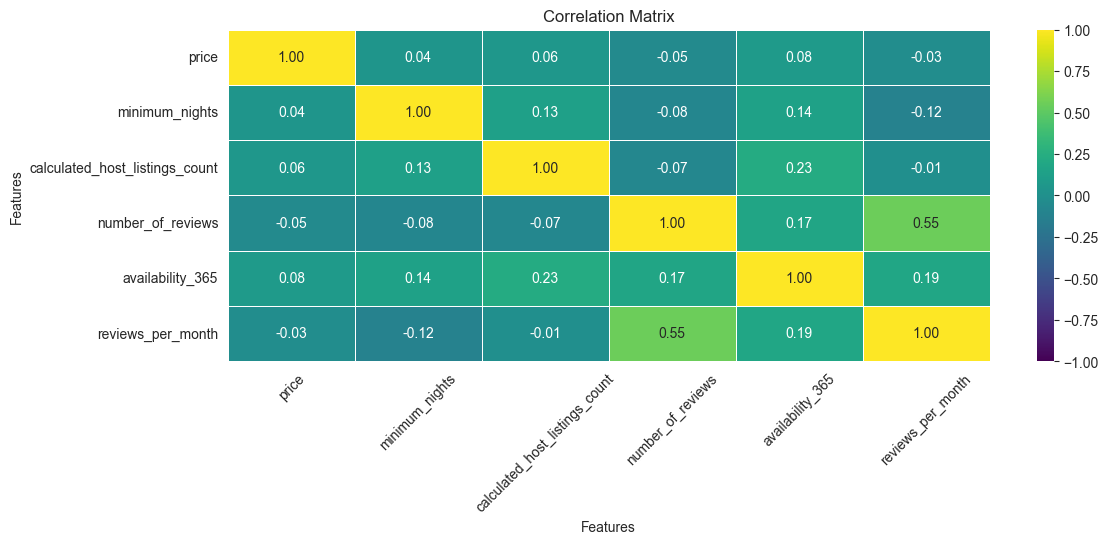

In [107]:
result = analyze_correlation_matrix(df, filter_column)

In [34]:
print(summary_factory.generate_summary("skewness", skewness))

- Highly skewed columns (suggesting log transformation): price, minimum_nights, calculated_host_listings_count, number_of_reviews, reviews_per_month
- Moderately skewed columns (suggesting square root transformation): availability_365

Detailed Skewness Values:

                        Column  Skewness
                         price 19.118939
                minimum_nights 21.827275
calculated_host_listings_count  7.933174
             number_of_reviews  3.690635
              availability_365  0.763408
             reviews_per_month  3.130189
